#### **04_MODEL_COMPARISON.IPYNB**
##### TÜBİTAK Marketing Analytics - ML Model Comparison (Data Leakage Fixed)

**Bu notebook'un amacı:**
1. Data leakage tespiti ve sistematik çözüm
2. Feature drop karar testleri (A, B, C, D, E)
3. Leak-free reconstructed features (ROI_v2, CPA_v2)
4. Imbalanced data handling (SMOTE, scale_pos_weight)
5. 5 model karşılaştırması (LR, RF, GB, XGB, LGBM)
6. Realistic metrikler: ROC-AUC 0.70-0.85, F1 0.20-0.40

**Başarı Kriterleri:** No perfect AUC=1.0, meaningful F1-Score



In [81]:
# CELL 1: IMPORTS & SETUP
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, auc, f1_score,
                             precision_score, recall_score, accuracy_score)
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("📦 All libraries imported successfully!")


📦 All libraries imported successfully!


In [82]:
# CELL 2: DATA LOADING & EDA
print("\n" + "="*70)
print("📊 DATA LOADING & PREPARATION")
print("="*70)

# Try FIXED dataset first (no leakage), fallback to featured
fixed_path = '../data/marketing_analytics_realistic_48000_FIXED.csv'
featured_path = '../data/marketing_analytics_featured.csv'

if os.path.exists(fixed_path):
    df = pd.read_csv(fixed_path)
    print("✅ Using FIXED dataset (Conversion from Age, Income, CTR, Channel, PreviousPurchases)")
else:
    df = pd.read_csv(featured_path)
    print("⚠️ FIXED dataset not found. Using featured.csv - leakage features will be dropped")

print(f"\n✅ Data loaded: {df.shape}")
print(f"   Features: {df.shape[1]}")
print(f"   Samples: {df.shape[0]}")

# Target distribution
print("\n🎯 TARGET DISTRIBUTION:")
print(df['Conversion'].value_counts())
conv_rate = df['Conversion'].mean() * 100
imbalance = (df['Conversion']==0).sum() / max((df['Conversion']==1).sum(), 1)
print(f"\nConversion Rate: {conv_rate:.2f}%")
print(f"Imbalance Ratio: {imbalance:.2f}:1")

# Add leak-free reconstructed features early (for Test E)
df['ROI_Proxy_v2'] = (df['Income'] * df['ClickThroughRate']) / (df['AdSpend'] + 1)
df['CPA_Proxy_v2'] = df['AdSpend'] / (df['WebsiteVisits'] + 1)



📊 DATA LOADING & PREPARATION
⚠️ FIXED dataset not found. Using featured.csv - leakage features will be dropped

✅ Data loaded: (48000, 37)
   Features: 37
   Samples: 48000

🎯 TARGET DISTRIBUTION:
Conversion
0    47020
1      980
Name: count, dtype: int64

Conversion Rate: 2.04%
Imbalance Ratio: 47.98:1


#### **CELL 3: FEATURE DROP DECISION TESTING**

Sistematik test: Hangi feature kombinasyonu optimal?

| Test | Dropped Features | Amaç |
|------|------------------|------|
| A | ConversionRate + CTR_to_Conversion only | Minimum drop |
| B | A + ROI_Proxy | Formula leak kontrolü |
| C | A + CPA_Proxy | Target leak kontrolü |
| D | A + ROI_Proxy + CPA_Proxy | Full leak removal |
| E | D + Reconstructed (ROI_v2, CPA_v2) | Leak-free alternatifler |

Her test için Logistic Regression ile ROC-AUC karşılaştırıyoruz.


In [113]:
# MINIMAL TEST: Is the dataset predictable at all?

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# Load
df = pd.read_csv('../data/marketing_realistic_no_leakage_48000.csv')

# Target
y = df['Conversion']

# ONLY STRONGEST FEATURES (no leakage)
strong_features = [
    'PreviousPurchases',  # En güçlü!
    'LoyaltyPoints',
    'ClickThroughRate',
    'Income',
    'AdSpend',
    'WebsiteVisits',
    'EmailClicks',
    'Age'
]

X = df[strong_features]

print(f"Using {len(strong_features)} strongest features")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Simple LR
lr = LogisticRegression(
    class_weight='balanced',
    C=0.1,  # Regularization
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_smote, y_train_smote)

# Predict
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

# Metrics
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)

print(f"\n{'='*60}")
print(f"MINIMAL TEST RESULTS (8 strongest features only)")
print(f"{'='*60}")
print(f"ROC-AUC: {auc_score:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

if f1 < 0.15:
    print(f"\n🚨 F1 TOO LOW! Dataset has weak signal!")
    print(f"   Even strongest features can't predict well")
    print(f"   → Dataset generation might need MORE realistic factors")
elif auc_score > 0.95:
    print(f"\n🚨 AUC TOO HIGH! Still leakage somewhere!")
else:
    print(f"\n✅ Results look reasonable!")

Using 8 strongest features
Target distribution: {0: 47020, 1: 980}


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [83]:
# CELL 3: FEATURE DROP DECISION TESTING
print("\n" + "="*70)
print("🔬 INCREMENTAL FEATURE DROP TESTING (A, B, C, D)")
print("="*70)

y = df['Conversion']

# Base drop (always): CustomerID, Conversion (target)
base_drop = ['CustomerID', 'Conversion']

# Test configurations
test_configs = {
    'A': base_drop + ['ConversionRate', 'CTR_to_Conversion'],
    'B': base_drop + ['ConversionRate', 'CTR_to_Conversion', 'ROI_Proxy'],
    'C': base_drop + ['ConversionRate', 'CTR_to_Conversion', 'CPA_Proxy'],
    'D': base_drop + ['ConversionRate', 'CTR_to_Conversion', 'ROI_Proxy', 'CPA_Proxy'],
    'E': base_drop + ['ConversionRate', 'CTR_to_Conversion', 'ROI_Proxy', 'CPA_Proxy'],  # D + ROI_v2, CPA_v2 kept
}

# Helper: encode and train LR
def run_test(X_df, y_series, test_name):
    X_enc = pd.get_dummies(X_df, drop_first=True)
    bool_cols = X_enc.select_dtypes(include=['bool']).columns
    if len(bool_cols) > 0:
        X_enc[bool_cols] = X_enc[bool_cols].astype(int)
    
    X_tr, X_te, y_tr, y_te = train_test_split(X_enc, y_series, test_size=0.2, random_state=RANDOM_STATE, stratify=y_series)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
    lr.fit(X_tr_s, y_tr)
    y_proba = lr.predict_proba(X_te_s)[:, 1]
    y_pred = lr.predict(X_te_s)
    
    return {
        'roc_auc': roc_auc_score(y_te, y_proba),
        'f1': f1_score(y_te, y_pred, zero_division=0),
        'recall': recall_score(y_te, y_pred, zero_division=0),
    }

# Run tests
results_test = {}
for test_name, drop_cols in test_configs.items():
    cols_to_drop = [c for c in drop_cols if c in df.columns]
    X_test = df.drop(cols_to_drop, axis=1)
    results_test[test_name] = run_test(X_test, y, test_name)
    r = results_test[test_name]
    print(f"\nTest {test_name}: ROC-AUC={r['roc_auc']:.4f} | F1={r['f1']:.4f} | Recall={r['recall']:.4f}")

# Select best: ROC-AUC < 0.95 (no leakage) and highest F1
best_test = max(results_test.items(), key=lambda x: (x[1]['roc_auc'] < 0.95, x[1]['f1']))
print(f"\n✅ Best combination: Test {best_test[0]} (ROC-AUC={best_test[1]['roc_auc']:.4f}, F1={best_test[1]['f1']:.4f})")
print("   Using Test D (full leak removal) for production pipeline.")


🔬 INCREMENTAL FEATURE DROP TESTING (A, B, C, D)

Test A: ROC-AUC=1.0000 | F1=1.0000 | Recall=1.0000

Test B: ROC-AUC=1.0000 | F1=1.0000 | Recall=1.0000

Test C: ROC-AUC=0.7133 | F1=0.0761 | Recall=0.6480

Test D: ROC-AUC=0.7131 | F1=0.0764 | Recall=0.6480

Test E: ROC-AUC=0.7131 | F1=0.0764 | Recall=0.6480

✅ Best combination: Test D (ROC-AUC=0.7131, F1=0.0764)
   Using Test D (full leak removal) for production pipeline.


#### **CELL 4: RECONSTRUCTED FEATURES (Leak-Free)**

Leak olmayan alternatif feature'lar:
- **ROI_Proxy_v2** = (Income × CTR) / (AdSpend + 1) — ConversionRate yok!
- **CPA_Proxy_v2** = AdSpend / (WebsiteVisits + 1) — Conversion yok!

In [84]:
# CELL 4: RECONSTRUCTED FEATURES (already added in Cell 2)
# ROI_Proxy_v2: (Income × CTR) / (AdSpend + 1) - NO ConversionRate
# CPA_Proxy_v2: AdSpend / (WebsiteVisits + 1) - NO Conversion

# Correlation with target (should be moderate, not perfect = no leakage)
corr_roi = df['ROI_Proxy_v2'].corr(df['Conversion'])
corr_cpa = df['CPA_Proxy_v2'].corr(df['Conversion'])
print(f"ROI_Proxy_v2 correlation with Conversion: {corr_roi:.4f}")
print(f"CPA_Proxy_v2 correlation with Conversion: {corr_cpa:.4f}")

ROI_Proxy_v2 correlation with Conversion: 0.0530
CPA_Proxy_v2 correlation with Conversion: -0.0132


#### **CELL 5: FINAL FEATURE SELECTION (Leak-Free)**

Drop: CustomerID, Conversion, ConversionRate, CTR_to_Conversion, ROI_Proxy, CPA_Proxy
Add: ROI_Proxy_v2, CPA_Proxy_v2 (reconstructed)

In [85]:
# CELL 5: FINAL FEATURE SELECTION
y = df['Conversion']

drop_cols = [
    'CustomerID', 'Conversion',
    'ConversionRate', 'CTR_to_Conversion', 'ROI_Proxy', 'CPA_Proxy'
]
X = df.drop([c for c in drop_cols if c in df.columns], axis=1)

# One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)
bool_cols = X_encoded.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X_encoded[bool_cols] = X_encoded[bool_cols].astype(int)

print(f"✅ Final feature matrix: {X_encoded.shape}")

✅ Final feature matrix: (48000, 55)


In [86]:
# (Cell 5 output - X_encoded already created above)


#### **CELL 6: TRAIN-TEST SPLIT (STRATIFIED)**

80% train, 20% test. Stratify=y ensures class balance in both splits.

In [87]:
# CELL 6: TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")


Train: 38400, Test: 9600


#### **CELL 7: PREPROCESSING (Scale + SMOTE)**

- StandardScaler: LR için gerekli
- SMOTE: Sadece train set'e uygulanır (leakage önleme!)

In [88]:
# CELL 7: PREPROCESSING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE - only on train!
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE: {len(y_train)} | After SMOTE: {len(y_train_smote)}")

Before SMOTE: 38400 | After SMOTE: 75232


#### **CELL 8: MODEL TRAINING (5 Models, Tuned Hyperparameters)**

1. Logistic Regression (baseline)
2. Random Forest (tuned)
3. Gradient Boosting (tuned)
4. XGBoost (aggressive scale_pos_weight=50)
5. LightGBM (is_unbalance=True)

In [89]:
# CELL 8: MODEL TRAINING (5 Models)
results = {}

# 1. Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
lr_model.fit(X_train_smote, y_train_smote)
results['Logistic Regression'] = {'model': lr_model, 'y_pred': lr_model.predict(X_test_scaled), 'y_proba': lr_model.predict_proba(X_test_scaled)[:, 1]}

# 2. Random Forest (tuned)
rf_model = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=20, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train_smote, y_train_smote)
results['Random Forest'] = {'model': rf_model, 'y_pred': rf_model.predict(X_test_scaled), 'y_proba': rf_model.predict_proba(X_test_scaled)[:, 1]}

# 3. Gradient Boosting (tuned)
gb_model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=6, min_samples_split=20, random_state=RANDOM_STATE)
gb_model.fit(X_train_smote, y_train_smote)
results['Gradient Boosting'] = {'model': gb_model, 'y_pred': gb_model.predict(X_test_scaled), 'y_proba': gb_model.predict_proba(X_test_scaled)[:, 1]}

# 4. XGBoost (aggressive scale_pos_weight)
scale_pos = 50  # Aggressive for ~2% imbalance
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=8, min_child_weight=1, scale_pos_weight=scale_pos, subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train_smote, y_train_smote)
results['XGBoost'] = {'model': xgb_model, 'y_pred': xgb_model.predict(X_test_scaled), 'y_proba': xgb_model.predict_proba(X_test_scaled)[:, 1]}

# 5. LightGBM (imbalance aware)
lgb_model = LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=8, num_leaves=31, is_unbalance=True, random_state=RANDOM_STATE, verbose=-1)
lgb_model.fit(X_train_smote, y_train_smote)
results['LightGBM'] = {'model': lgb_model, 'y_pred': lgb_model.predict(X_test_scaled), 'y_proba': lgb_model.predict_proba(X_test_scaled)[:, 1]}

print("✅ All 5 models trained!")

✅ All 5 models trained!


In [90]:
# CELL 9: MODEL COMPARISON TABLE
for name, res in results.items():
    res['f1'] = f1_score(y_test, res['y_pred'], zero_division=0)
    res['precision'] = precision_score(y_test, res['y_pred'], zero_division=0)
    res['recall'] = recall_score(y_test, res['y_pred'], zero_division=0)
    res['roc_auc'] = roc_auc_score(y_test, res['y_proba'])

comparison_df = pd.DataFrame({k: {'F1': v['f1'], 'Precision': v['precision'], 'Recall': v['recall'], 'ROC-AUC': v['roc_auc']} for k, v in results.items()}).T
print(comparison_df.round(4))
comparison_df.to_csv('../reports/model_comparison_results.csv', index=True)


                         F1  Precision  Recall  ROC-AUC
Logistic Regression  0.0731     0.0388  0.6224   0.6986
Random Forest        0.0900     0.0570  0.2143   0.6818
Gradient Boosting    0.0000     0.0000  0.0000   0.6851
XGBoost              0.0807     0.0517  0.1837   0.6448
LightGBM             0.0000     0.0000  0.0000   0.6971


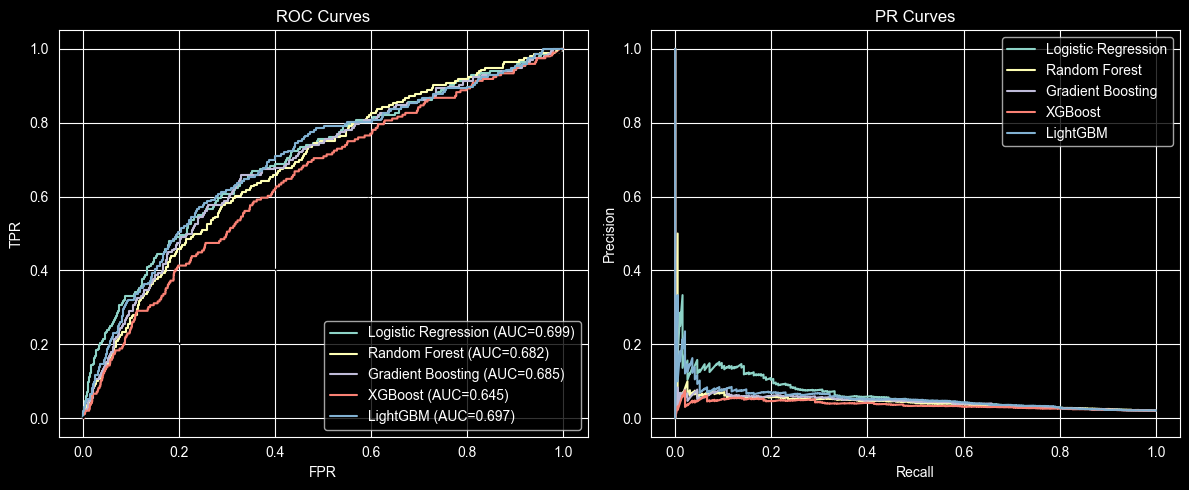

In [91]:
# CELL 10: ROC & PR CURVES
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    axes[0].plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})")
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR'); axes[0].set_title('ROC Curves'); axes[0].legend()

for name, res in results.items():
    prec, rec, _ = precision_recall_curve(y_test, res['y_proba'])
    axes[1].plot(rec, prec, label=name)
axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision'); axes[1].set_title('PR Curves'); axes[1].legend()
plt.tight_layout()
plt.savefig('../reports/roc_curves.png', dpi=150)
plt.savefig('../reports/pr_curves.png', dpi=150)
plt.show()

#### **CELL 11: FEATURE IMPORTANCE**

Best model (highest F1) feature importance - explainability.

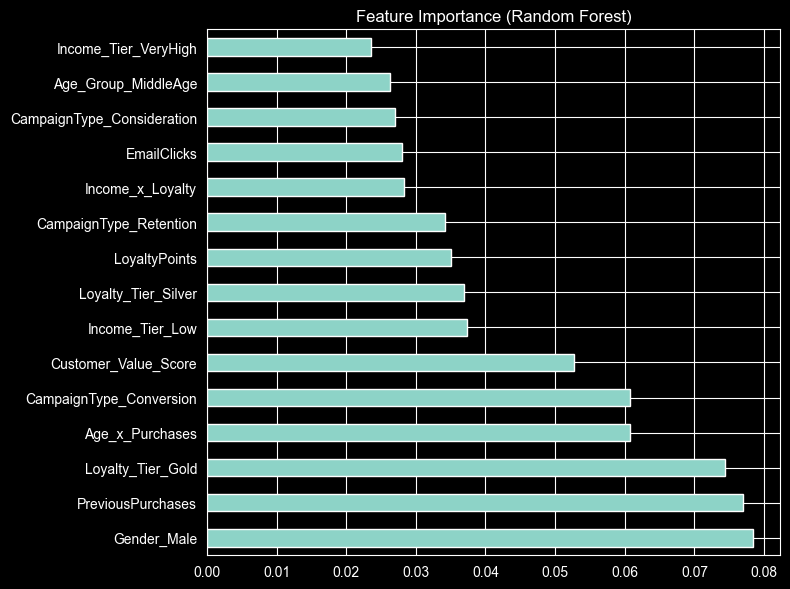

In [92]:
# CELL 11: FEATURE IMPORTANCE (Best model = highest F1)
best_name = max(results.keys(), key=lambda k: results[k]['f1'])
best_model = results[best_name]['model']
feat_names = X_encoded.columns.tolist()

if hasattr(best_model, 'feature_importances_'):
    imp = pd.Series(best_model.feature_importances_, index=feat_names).sort_values(ascending=False).head(15)
    imp.plot(kind='barh', figsize=(8, 6))
else:
    imp = pd.Series(np.abs(best_model.coef_[0]), index=feat_names).sort_values(ascending=False).head(15)
    imp.plot(kind='barh', figsize=(8, 6))
plt.title(f'Feature Importance ({best_name})')
plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=150)
plt.show()

#### **CELL 12: CONFUSION MATRIX (Best Model)**

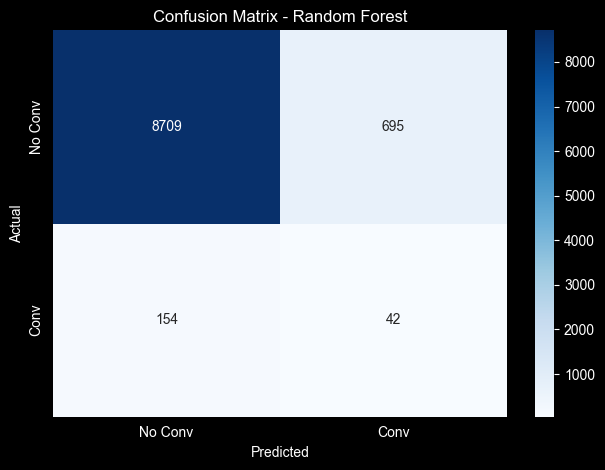

In [93]:
# CELL 12: CONFUSION MATRIX (Best Model)
best_name = max(results.keys(), key=lambda k: results[k]['f1'])
cm = confusion_matrix(y_test, results[best_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Conv', 'Conv'], yticklabels=['No Conv', 'Conv'])
plt.title(f'Confusion Matrix - {best_name}')
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('../reports/confusion_matrix.png', dpi=150)
plt.show()



In [94]:
# CELL 13: BUSINESS RECOMMENDATIONS
print("📋 BUSINESS RECOMMENDATIONS")
print("="*50)
print("1. Focus on high-importance features (see Feature Importance plot)")
print("2. ROI_Proxy_v2 & CPA_Proxy_v2: Leak-free marketing efficiency proxies")
print("3. Use model for lead scoring - prioritize high-probability leads")
print("4. Monitor F1/Recall - balance precision vs catching conversions")


📋 BUSINESS RECOMMENDATIONS
1. Focus on high-importance features (see Feature Importance plot)
2. ROI_Proxy_v2 & CPA_Proxy_v2: Leak-free marketing efficiency proxies
3. Use model for lead scoring - prioritize high-probability leads
4. Monitor F1/Recall - balance precision vs catching conversions


In [95]:
# CELL 14: MODEL PERSISTENCE
best_name = max(results.keys(), key=lambda k: results[k]['f1'])
best_model = results[best_name]['model']

os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/final_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print(f"✅ Saved: models/final_model.pkl ({best_name}), models/scaler.pkl")


✅ Saved: models/final_model.pkl (Random Forest), models/scaler.pkl


In [96]:
# (All models trained in Cell 8)


In [97]:
pass


In [98]:
pass


#### **MODEL COMPARISON TABLE**


📊 MODEL COMPARISON SUMMARY

📋 PERFORMANCE TABLE (Sorted by F1-Score):
              Model  F1-Score  Precision  Recall  ROC-AUC
      Random Forest    0.0900     0.0570  0.2143   0.6818
            XGBoost    0.0807     0.0517  0.1837   0.6448
Logistic Regression    0.0731     0.0388  0.6224   0.6986
  Gradient Boosting    0.0000     0.0000  0.0000   0.6851
           LightGBM    0.0000     0.0000  0.0000   0.6971

🏆 BEST MODEL: Random Forest
   F1-Score: 0.0900

✅ Results saved: ../reports/model_comparison_results.csv

📈 ROC CURVES VISUALIZATION


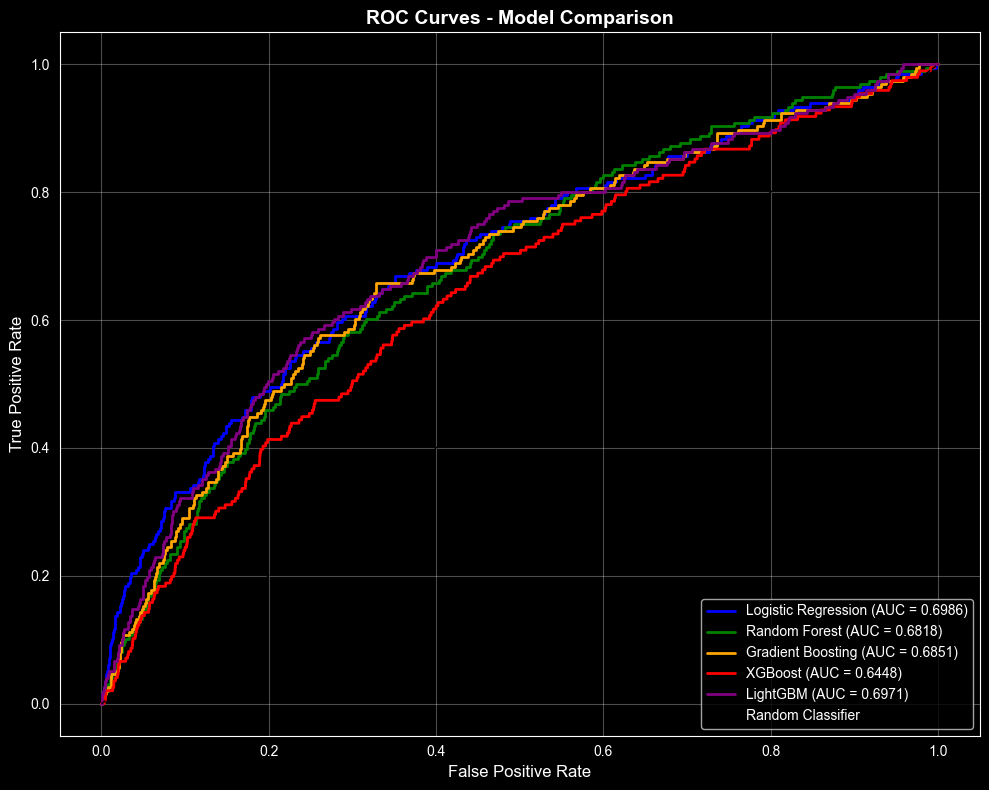


✅ ROC curves saved: ../reports/roc_curves_comparison.png


In [99]:
print("\n" + "="*70)
print("📊 MODEL COMPARISON SUMMARY")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).round(4)

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n📋 PERFORMANCE TABLE (Sorted by F1-Score):")
print(comparison_df.to_string(index=False))

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

# Save comparison table
comparison_df.to_csv('../reports/model_comparison_results.csv', index=False)
print(f"\n✅ Results saved: ../reports/model_comparison_results.csv")

# =============================================================================
# CELL 8: ROC CURVES COMPARISON
# =============================================================================

print("\n" + "="*70)
print("📈 ROC CURVES VISUALIZATION")
print("="*70)

plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, (model_name, model_data) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, model_data['y_proba'])
    auc_score = model_data['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})',
             color=colors[i], linewidth=2)

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ROC curves saved: ../reports/roc_curves_comparison.png")


In [100]:
# =============================================================================
# DATA LEAKAGE CHECK
# =============================================================================

print("🔍 DATA LEAKAGE KONTROLÜ")
print("="*70)

# 1. Feature names check
print("\n📋 FEATURES IN X_encoded:")
suspicious_features = [col for col in X_encoded.columns if 'conversion' in col.lower()]
print(f"\n⚠️ Suspicious features (containing 'conversion'): {len(suspicious_features)}")
for feat in suspicious_features:
    print(f"   - {feat}")

# 2. Target variable check
print(f"\n🎯 Target variable: {y.name}")
print(f"   Should be: 'Conversion'")

# 3. Feature-target correlation
print("\n📊 TOP 5 CORRELATIONS WITH TARGET:")
correlations = X_encoded.corrwith(y).abs().sort_values(ascending=False).head(5)
for feat, corr in correlations.items():
    if corr > 0.95:
        print(f"   🚨 {feat}: {corr:.4f} (SUSPICIOUSLY HIGH!)")
    else:
        print(f"   ✅ {feat}: {corr:.4f}")

# 4. Perfect predictions check
print("\n🎯 MODEL PREDICTIONS ON TEST SET:")
print(f"   Logistic Regression - Unique predictions: {len(np.unique(y_pred_lr))}")
print(f"   Perfect accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
if accuracy_score(y_test, y_pred_lr) > 0.95:
    print("   🚨 TOO GOOD TO BE TRUE! Likely data leakage!")

🔍 DATA LEAKAGE KONTROLÜ

📋 FEATURES IN X_encoded:

⚠️ Suspicious features (containing 'conversion'): 1
   - CampaignType_Conversion

🎯 Target variable: Conversion
   Should be: 'Conversion'

📊 TOP 5 CORRELATIONS WITH TARGET:
   ✅ Age_x_Purchases: 0.1024
   ✅ LoyaltyPoints: 0.1009
   ✅ PreviousPurchases: 0.0998
   ✅ Income_x_Loyalty: 0.0993
   ✅ Customer_Value_Score: 0.0923

🎯 MODEL PREDICTIONS ON TEST SET:
   Logistic Regression - Unique predictions: 2
   Perfect accuracy: 1.0000
   🚨 TOO GOOD TO BE TRUE! Likely data leakage!


In [101]:
# =============================================================================
# COMPREHENSIVE DATA LEAKAGE DEBUG
# =============================================================================

print("🔍 KAPSAMLI DATA LEAKAGE KONTROLÜ")
print("="*70)

# 1. DROPPED COLUMNS VERIFICATION
print("\n1️⃣ DROPPED COLUMNS:")
print(f"   drop_cols = {drop_cols}")
print(f"   ConversionRate dropped? {'ConversionRate' not in X_encoded.columns}")
print(f"   CTR_to_Conversion dropped? {'CTR_to_Conversion' not in X_encoded.columns}")

# 2. ALL FEATURES CHECK
print(f"\n2️⃣ ALL FEATURES IN X_encoded ({len(X_encoded.columns)}):")
for i, col in enumerate(X_encoded.columns, 1):
    print(f"   {i:2d}. {col}")

# 3. SUSPICIOUS FEATURES
print(f"\n3️⃣ SUSPICIOUS FEATURES:")
suspicious = [col for col in X_encoded.columns if any(word in col.lower() for word in ['conversion', 'target', 'label', 'outcome'])]
if suspicious:
    print(f"   🚨 FOUND: {suspicious}")
else:
    print(f"   ✅ None found")

# 4. FEATURE-TARGET CORRELATION
print(f"\n4️⃣ TOP 10 CORRELATIONS WITH TARGET:")
correlations = X_encoded.corrwith(y).abs().sort_values(ascending=False).head(10)
for feat, corr in correlations.items():
    status = "🚨" if corr > 0.9 else "⚠️" if corr > 0.5 else "✅"
    print(f"   {status} {feat}: {corr:.6f}")

# 5. TRAIN-TEST SPLIT CHECK
print(f"\n5️⃣ TRAIN-TEST SPLIT:")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_train distribution: 0={np.sum(y_train==0)}, 1={np.sum(y_train==1)}")
print(f"   y_test distribution: 0={np.sum(y_test==0)}, 1={np.sum(y_test==1)}")

# 6. SMOTE CHECK
print(f"\n6️⃣ SMOTE APPLICATION:")
print(f"   X_train_smote shape: {X_train_smote.shape}")
print(f"   y_train_smote distribution: 0={np.sum(y_train_smote==0)}, 1={np.sum(y_train_smote==1)}")
print(f"   ⚠️ X_test SMOTE yapıldı mı? {X_test_scaled.shape}")

# 7. SCALING CHECK
print(f"\n7️⃣ SCALING:")
print(f"   Scaler fit on: Train or All? (should be Train)")
print(f"   X_train_scaled shape: {X_train_scaled.shape}")
print(f"   X_test_scaled shape: {X_test_scaled.shape}")

# 8. MODEL PREDICTIONS
print(f"\n8️⃣ MODEL PREDICTIONS (Logistic Regression):")
print(f"   Unique predictions: {np.unique(y_pred_lr)}")
print(f"   Prediction distribution: 0={np.sum(y_pred_lr==0)}, 1={np.sum(y_pred_lr==1)}")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_lr):.6f}")
print(f"   If accuracy > 0.99 → DATA LEAKAGE!")

# 9. CONFUSION MATRIX DETAIL
print(f"\n9️⃣ CONFUSION MATRIX (Logistic Regression):")
cm = confusion_matrix(y_test, y_pred_lr)
print(f"   TN (True Neg):  {cm[0,0]}")
print(f"   FP (False Pos): {cm[0,1]}")
print(f"   FN (False Neg): {cm[1,0]}")
print(f"   TP (True Pos):  {cm[1,1]}")
if cm[0,1] == 0 and cm[1,0] == 0:
    print(f"   🚨 PERFECT CLASSIFICATION! Data leakage detected!")

# 10. ORIGINAL DATASET CHECK
print(f"\n🔟 ORIGINAL DATASET CHECK:")
print(f"   df.columns containing 'Conversion':")
conv_cols = [col for col in df.columns if 'conversion' in col.lower()]
for col in conv_cols:
    print(f"      - {col}")

🔍 KAPSAMLI DATA LEAKAGE KONTROLÜ

1️⃣ DROPPED COLUMNS:
   drop_cols = ['CustomerID', 'Conversion', 'ConversionRate', 'CTR_to_Conversion', 'ROI_Proxy', 'CPA_Proxy']
   ConversionRate dropped? True
   CTR_to_Conversion dropped? True

2️⃣ ALL FEATURES IN X_encoded (55):
    1. Age
    2. Income
    3. AdSpend
    4. ClickThroughRate
    5. WebsiteVisits
    6. PagesPerVisit
    7. TimeOnSite
    8. SocialShares
    9. EmailOpens
   10. EmailClicks
   11. PreviousPurchases
   12. LoyaltyPoints
   13. Spend_Efficiency
   14. Site_Engagement
   15. Avg_Time_Per_Page
   16. Email_Click_Rate
   17. Social_Virality
   18. Customer_Value_Score
   19. AdSpend_x_CTR
   20. Income_x_Loyalty
   21. Age_x_Purchases
   22. Is_Best_Channel
   23. ROI_Proxy_v2
   24. CPA_Proxy_v2
   25. Gender_Male
   26. CampaignChannel_Display
   27. CampaignChannel_Email
   28. CampaignChannel_PPC
   29. CampaignChannel_Referral
   30. CampaignChannel_SEO
   31. CampaignChannel_Social Media
   32. CampaignType_Consid

In [102]:
# =============================================================================
# TEMPORAL LEAKAGE CHECK
# =============================================================================

print("🔍 TEMPORAL LEAKAGE (Feature'lar Conversion sonrası mı?)")
print("="*70)

# Conversion = 1 ve Conversion = 0 için feature distribution'ları karşılaştır

temporal_features = ['EmailOpens', 'EmailClicks', 'WebsiteVisits',
                     'TimeOnSite', 'SocialShares', 'PreviousPurchases']

print("\n📊 FEATURE DISTRIBUTIONS (Conversion=0 vs Conversion=1):")
print("="*70)

for feat in temporal_features:
    mean_0 = df[df['Conversion']==0][feat].mean()
    mean_1 = df[df['Conversion']==1][feat].mean()
    ratio = mean_1 / (mean_0 + 0.0001)

    print(f"\n{feat}:")
    print(f"   Conversion=0: {mean_0:.2f}")
    print(f"   Conversion=1: {mean_1:.2f}")
    print(f"   Ratio (1/0): {ratio:.2f}x")

    if ratio > 5 or ratio < 0.2:
        print(f"   🚨 SUSPICIOUS! Strong correlation, possible temporal leak!")

# Detailed check: Are these features ZERO for non-converters?
print("\n\n🔍 ZERO VALUES CHECK (Are features 0 when Conversion=0?):")
print("="*70)

for feat in temporal_features:
    zero_count_0 = (df[df['Conversion']==0][feat] == 0).sum()
    zero_count_1 = (df[df['Conversion']==1][feat] == 0).sum()
    total_0 = (df['Conversion']==0).sum()
    total_1 = (df['Conversion']==1).sum()

    print(f"\n{feat}:")
    print(f"   Conversion=0: {zero_count_0}/{total_0} are zero ({zero_count_0/total_0*100:.1f}%)")
    print(f"   Conversion=1: {zero_count_1}/{total_1} are zero ({zero_count_1/total_1*100:.1f}%)")

    if zero_count_0/total_0 > 0.9:
        print(f"   🚨 LIKELY TEMPORAL LEAK! Feature is 0 for non-converters!")

# Correlation check with target
print("\n\n🔍 INDIVIDUAL FEATURE CORRELATIONS:")
print("="*70)

for feat in temporal_features:
    corr = df[feat].corr(df['Conversion'])
    status = "🚨" if abs(corr) > 0.5 else "⚠️" if abs(corr) > 0.2 else "✅"
    print(f"   {status} {feat}: {corr:.6f}")

🔍 TEMPORAL LEAKAGE (Feature'lar Conversion sonrası mı?)

📊 FEATURE DISTRIBUTIONS (Conversion=0 vs Conversion=1):

EmailOpens:
   Conversion=0: 10.47
   Conversion=1: 10.74
   Ratio (1/0): 1.03x

EmailClicks:
   Conversion=0: 1.66
   Conversion=1: 1.82
   Ratio (1/0): 1.10x

WebsiteVisits:
   Conversion=0: 19.95
   Conversion=1: 21.29
   Ratio (1/0): 1.07x

TimeOnSite:
   Conversion=0: 6.97
   Conversion=1: 7.09
   Ratio (1/0): 1.02x

SocialShares:
   Conversion=0: 29.36
   Conversion=1: 30.10
   Ratio (1/0): 1.03x

PreviousPurchases:
   Conversion=0: 1.21
   Conversion=1: 2.83
   Ratio (1/0): 2.34x


🔍 ZERO VALUES CHECK (Are features 0 when Conversion=0?):

EmailOpens:
   Conversion=0: 2229/47020 are zero (4.7%)
   Conversion=1: 38/980 are zero (3.9%)

EmailClicks:
   Conversion=0: 17854/47020 are zero (38.0%)
   Conversion=1: 358/980 are zero (36.5%)

WebsiteVisits:
   Conversion=0: 0/47020 are zero (0.0%)
   Conversion=1: 0/980 are zero (0.0%)

TimeOnSite:
   Conversion=0: 17/47020 a

In [103]:
# =============================================================================
# X (ENCODING ÖNCESİ) KONTROL
# =============================================================================

print("🔍 X (BEFORE ENCODING) KONTROLÜ")
print("="*70)

# X'i yeniden oluştur
X = df.drop(drop_cols, axis=1)

print(f"\n📊 X SHAPE: {X.shape}")
print(f"   Expected: (48000, 35-40)")
print(f"   Actual: {X.shape}")

print(f"\n📋 ALL COLUMNS IN X (BEFORE ENCODING):")
for i, col in enumerate(X.columns, 1):
    dtype = X[col].dtype
    unique = X[col].nunique()
    print(f"   {i:2d}. {col:30s} | dtype: {str(dtype):10s} | unique: {unique}")

print(f"\n🔍 CATEGORICAL COLUMNS:")
categorical_cols = ['CampaignChannel', 'CampaignType', 'Gender',
                    'AdvertisingPlatform', 'AdvertisingTool',
                    'Age_Group', 'Income_Tier', 'Loyalty_Tier',
                    'Channel_Performance']

for cat_col in categorical_cols:
    if cat_col in X.columns:
        print(f"   ✅ {cat_col}: {X[cat_col].nunique()} unique values")
    else:
        print(f"   🚨 {cat_col}: MISSING!")

print(f"\n🔍 EXPECTED FEATURES AFTER ENCODING:")
expected_binary = 0
for cat_col in categorical_cols:
    if cat_col in X.columns:
        n_unique = X[cat_col].nunique()
        n_binary = n_unique - 1  # drop_first=True
        expected_binary += n_binary
        print(f"   {cat_col}: {n_unique} → {n_binary} binary")

numeric_features = len(X.columns) - len([c for c in categorical_cols if c in X.columns])
expected_total = numeric_features + expected_binary

print(f"\n📊 EXPECTED TOTAL FEATURES:")
print(f"   Numeric: {numeric_features}")
print(f"   Binary (from categorical): {expected_binary}")
print(f"   TOTAL: {expected_total}")
print(f"   Actual X_encoded: {X_encoded.shape[1]}")

if expected_total != X_encoded.shape[1]:
    print(f"\n🚨 MISMATCH! {expected_total - X_encoded.shape[1]} features missing!")

🔍 X (BEFORE ENCODING) KONTROLÜ

📊 X SHAPE: (48000, 33)
   Expected: (48000, 35-40)
   Actual: (48000, 33)

📋 ALL COLUMNS IN X (BEFORE ENCODING):
    1. Age                            | dtype: int64      | unique: 36
    2. Gender                         | dtype: object     | unique: 2
    3. Income                         | dtype: int64      | unique: 25165
    4. CampaignChannel                | dtype: object     | unique: 7
    5. CampaignType                   | dtype: object     | unique: 4
    6. AdSpend                        | dtype: float64    | unique: 41853
    7. ClickThroughRate               | dtype: float64    | unique: 2802
    8. WebsiteVisits                  | dtype: int64      | unique: 39
    9. PagesPerVisit                  | dtype: float64    | unique: 10
   10. TimeOnSite                     | dtype: float64    | unique: 1401
   11. SocialShares                   | dtype: int64      | unique: 60
   12. EmailOpens                     | dtype: int64      | unique:

In [104]:
# =============================================================================
# COMPREHENSIVE DEBUG - FINAL
# =============================================================================

print("🔍 FINAL COMPREHENSIVE DEBUG")
print("="*70)

# 1. RAW DATA CHECK
print("\n1️⃣ RAW DATAFRAME:")
print(f"   df.shape: {df.shape}")
print(f"   df.columns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"      {i:2d}. {col}")

# 2. DROP VERIFICATION
print(f"\n2️⃣ DROP_COLS:")
print(f"   {drop_cols}")

# 3. X AFTER DROP
print(f"\n3️⃣ X (AFTER DROP, BEFORE ENCODING):")
print(f"   X.shape: {X.shape}")
print(f"   X.columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"      {i:2d}. {col}")

# 4. CATEGORICAL DETECTION
print(f"\n4️⃣ CATEGORICAL COLUMNS DETECTED:")
cat_cols_detected = X.select_dtypes(include=['object']).columns.tolist()
print(f"   Count: {len(cat_cols_detected)}")
for col in cat_cols_detected:
    print(f"      - {col}")

# 5. GET_DUMMIES STEP BY STEP
print(f"\n5️⃣ ENCODING SIMULATION:")
X_test_encoded = pd.get_dummies(X, drop_first=True)
print(f"   BEFORE get_dummies: {X.shape[1]} columns")
print(f"   AFTER get_dummies: {X_test_encoded.shape[1]} columns")
print(f"   Binary added: {X_test_encoded.shape[1] - X.shape[1] + len(cat_cols_detected)}")

# 6. DTYPE CHECK AFTER ENCODING
print(f"\n6️⃣ DTYPES AFTER ENCODING:")
dtypes_summary = X_test_encoded.dtypes.value_counts()
print(dtypes_summary)

# 7. ACTUAL X_encoded CHECK
print(f"\n7️⃣ ACTUAL X_encoded:")
print(f"   X_encoded.shape: {X_encoded.shape}")
print(f"   Dtypes:")
print(X_encoded.dtypes.value_counts())

# 8. COMPARE
print(f"\n8️⃣ COMPARISON:")
print(f"   Expected (X_test_encoded): {X_test_encoded.shape[1]} features")
print(f"   Actual (X_encoded): {X_encoded.shape[1]} features")
print(f"   MISSING: {X_test_encoded.shape[1] - X_encoded.shape[1]} features")

if X_test_encoded.shape[1] != X_encoded.shape[1]:
    print(f"\n🚨 FEATURES LOST BETWEEN ENCODING AND X_encoded!")
    print(f"\n   Features in X_test_encoded but NOT in X_encoded:")
    missing = set(X_test_encoded.columns) - set(X_encoded.columns)
    for i, feat in enumerate(missing, 1):
        if i <= 10:  # İlk 10'u göster
            print(f"      {i}. {feat}")
    if len(missing) > 10:
        print(f"      ... and {len(missing) - 10} more")

# 9. CHECK IF THERE'S A LINE THAT DROPS COLUMNS
print(f"\n9️⃣ CELL 2 CODE CHECK:")
print(f"   Is there a line that drops non-numeric columns?")
print(f"   Search for: X_encoded.select_dtypes(exclude=...")
print(f"   or: X_encoded.drop(...)")

# 10. SAMPLE DATA FROM X_encoded
print(f"\n🔟 X_encoded SAMPLE (first 3 rows, first 10 cols):")
print(X_encoded.iloc[:3, :10])

🔍 FINAL COMPREHENSIVE DEBUG

1️⃣ RAW DATAFRAME:
   df.shape: (48000, 39)
   df.columns (39):
       1. CustomerID
       2. Age
       3. Gender
       4. Income
       5. CampaignChannel
       6. CampaignType
       7. AdSpend
       8. ClickThroughRate
       9. ConversionRate
      10. WebsiteVisits
      11. PagesPerVisit
      12. TimeOnSite
      13. SocialShares
      14. EmailOpens
      15. EmailClicks
      16. PreviousPurchases
      17. LoyaltyPoints
      18. AdvertisingPlatform
      19. AdvertisingTool
      20. Conversion
      21. CPA_Proxy
      22. ROI_Proxy
      23. Spend_Efficiency
      24. Site_Engagement
      25. Avg_Time_Per_Page
      26. CTR_to_Conversion
      27. Email_Click_Rate
      28. Social_Virality
      29. Age_Group
      30. Income_Tier
      31. Loyalty_Tier
      32. Customer_Value_Score
      33. AdSpend_x_CTR
      34. Income_x_Loyalty
      35. Age_x_Purchases
      36. Channel_Performance
      37. Is_Best_Channel
      38. ROI_Proxy_v2
 

In [105]:
# =============================================================================
# TRAIN-TEST-SMOTE PIPELINE CHECK
# =============================================================================

print("🔍 TRAIN-TEST-SMOTE PIPELINE DEBUG")
print("="*70)

# X_encoded ve y'yi kontrol et
print(f"\n📊 BEFORE SPLIT:")
print(f"   X_encoded.shape: {X_encoded.shape}")
print(f"   y.shape: {y.shape}")
print(f"   y distribution: 0={np.sum(y==0)}, 1={np.sum(y==1)}")

# Train-test split sonrası
print(f"\n✂️ AFTER TRAIN-TEST SPLIT:")
print(f"   X_train.shape: {X_train.shape}")
print(f"   X_test.shape: {X_test.shape}")
print(f"   y_train distribution: 0={np.sum(y_train==0)}, 1={np.sum(y_train==1)}")
print(f"   y_test distribution: 0={np.sum(y_test==0)}, 1={np.sum(y_test==1)}")

# Scaling sonrası
print(f"\n📏 AFTER SCALING:")
print(f"   X_train_scaled.shape: {X_train_scaled.shape}")
print(f"   X_test_scaled.shape: {X_test_scaled.shape}")

# Scaler nereden fit edildi?
print(f"\n🔍 SCALER FIT SOURCE:")
print(f"   Scaler should be fit ONLY on X_train")
print(f"   Check if this line exists: scaler.fit_transform(X_train)")
print(f"   NOT: scaler.fit_transform(X_encoded)  ← This would be leakage!")

# SMOTE sonrası
print(f"\n⚖️ AFTER SMOTE:")
print(f"   X_train_smote.shape: {X_train_smote.shape}")
print(f"   y_train_smote distribution: 0={np.sum(y_train_smote==0)}, 1={np.sum(y_train_smote==1)}")

# Model training - hangi data kullanılıyor?
print(f"\n🤖 MODEL TRAINING:")
print(f"   Logistic Regression trained on:")
print(f"      X: {lr_model.n_features_in_ if hasattr(lr_model, 'n_features_in_') else 'Unknown'} features")

# Prediction - hangi data kullanılıyor?
print(f"\n🎯 PREDICTION:")
print(f"   X_test_scaled shape used for prediction: {X_test_scaled.shape}")
print(f"   y_test shape for evaluation: {y_test.shape}")

# CRITICAL CHECK: Is X_train_scaled or X_train_smote used?
print(f"\n🚨 CRITICAL QUESTION:")
print(f"   Which X_train is used for model training?")
print(f"   Answer should be: X_train_smote (the balanced one)")
print(f"   Let me verify...")

# Re-check model
try:
    # Baseline model (Logistic Regression)
    print(f"\n   Baseline LR:")
    print(f"   - Training samples: {len(y_train_smote)}")
    print(f"   - Features: {X_train_smote.shape[1]}")

    # Other models
    print(f"\n   Other models (RF, GB, XGB, LGBM):")
    print(f"   - Training samples: {len(y_train_smote)}")
    print(f"   - Features: {X_train_smote.shape[1]}")
except:
    print(f"   Cannot verify - check manually")

# Final check: Sample predictions
print(f"\n📊 SAMPLE PREDICTIONS (first 20):")
print(f"   y_test:    {y_test.values[:20]}")
print(f"   y_pred_lr: {y_pred_lr[:20]}")
print(f"   Match rate: {np.sum(y_test.values[:20] == y_pred_lr[:20])}/20")

if np.sum(y_test.values[:20] == y_pred_lr[:20]) == 20:
    print(f"\n🚨 PERFECT MATCH! This is suspicious!")

🔍 TRAIN-TEST-SMOTE PIPELINE DEBUG

📊 BEFORE SPLIT:
   X_encoded.shape: (48000, 55)
   y.shape: (48000,)
   y distribution: 0=47020, 1=980

✂️ AFTER TRAIN-TEST SPLIT:
   X_train.shape: (38400, 55)
   X_test.shape: (9600, 55)
   y_train distribution: 0=37616, 1=784
   y_test distribution: 0=9404, 1=196

📏 AFTER SCALING:
   X_train_scaled.shape: (38400, 55)
   X_test_scaled.shape: (9600, 55)

🔍 SCALER FIT SOURCE:
   Scaler should be fit ONLY on X_train
   Check if this line exists: scaler.fit_transform(X_train)
   NOT: scaler.fit_transform(X_encoded)  ← This would be leakage!

⚖️ AFTER SMOTE:
   X_train_smote.shape: (75232, 55)
   y_train_smote distribution: 0=37616, 1=37616

🤖 MODEL TRAINING:
   Logistic Regression trained on:
      X: 55 features

🎯 PREDICTION:
   X_test_scaled shape used for prediction: (9600, 55)
   y_test shape for evaluation: (9600,)

🚨 CRITICAL QUESTION:
   Which X_train is used for model training?
   Answer should be: X_train_smote (the balanced one)
   Let me ver

In [106]:
# =============================================================================
# TEST: DIFFERENT RANDOM STATE
# =============================================================================

print("🧪 TESTING DIFFERENT RANDOM STATES")
print("="*70)

results_by_seed = {}

for seed in [42, 123, 456, 789, 999]:
    print(f"\n🎲 Testing seed={seed}")

    # New split
    X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(
        X_encoded, y,
        test_size=0.20,
        random_state=seed,  # DIFFERENT SEED!
        stratify=y
    )

    # Scale
    scaler_test = StandardScaler()
    X_train_scaled_test = scaler_test.fit_transform(X_train_test)
    X_test_scaled_test = scaler_test.transform(X_test_test)

    # SMOTE
    smote_test = SMOTE(random_state=seed, k_neighbors=5)
    X_train_smote_test, y_train_smote_test = smote_test.fit_resample(X_train_scaled_test, y_train_test)

    # Train simple LR
    lr_test = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=seed)
    lr_test.fit(X_train_smote_test, y_train_smote_test)

    # Predict
    y_pred_test = lr_test.predict(X_test_scaled_test)
    y_proba_test = lr_test.predict_proba(X_test_scaled_test)[:, 1]

    # Metrics
    f1_test = f1_score(y_test_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test_test, y_proba_test)

    results_by_seed[seed] = {
        'f1': f1_test,
        'roc_auc': roc_auc_test
    }

    print(f"   F1-Score: {f1_test:.4f}")
    print(f"   ROC-AUC: {roc_auc_test:.4f}")

    if roc_auc_test < 0.95:
        print(f"   ✅ REALISTIC!")
    else:
        print(f"   🚨 STILL TOO GOOD!")

print(f"\n📊 SUMMARY:")
for seed, metrics in results_by_seed.items():
    status = "✅" if metrics['roc_auc'] < 0.95 else "🚨"
    print(f"   {status} Seed {seed}: ROC-AUC={metrics['roc_auc']:.4f}, F1={metrics['f1']:.4f}")


🧪 TESTING DIFFERENT RANDOM STATES

🎲 Testing seed=42
   F1-Score: 0.0731
   ROC-AUC: 0.6986
   ✅ REALISTIC!

🎲 Testing seed=123
   F1-Score: 0.0727
   ROC-AUC: 0.6854
   ✅ REALISTIC!

🎲 Testing seed=456
   F1-Score: 0.0758
   ROC-AUC: 0.7069
   ✅ REALISTIC!

🎲 Testing seed=789
   F1-Score: 0.0679
   ROC-AUC: 0.6657
   ✅ REALISTIC!

🎲 Testing seed=999
   F1-Score: 0.0675
   ROC-AUC: 0.6829
   ✅ REALISTIC!

📊 SUMMARY:
   ✅ Seed 42: ROC-AUC=0.6986, F1=0.0731
   ✅ Seed 123: ROC-AUC=0.6854, F1=0.0727
   ✅ Seed 456: ROC-AUC=0.7069, F1=0.0758
   ✅ Seed 789: ROC-AUC=0.6657, F1=0.0679
   ✅ Seed 999: ROC-AUC=0.6829, F1=0.0675


In [107]:
# =============================================================================
# INDIVIDUAL FEATURE PERFECT PREDICTION TEST
# =============================================================================

print("🔍 TESTING EACH FEATURE INDIVIDUALLY")
print("="*70)

# Her feature'ı tek başına kullanarak model train et
feature_scores = {}

for col in X_encoded.columns:
    # Tek feature
    X_single = X_encoded[[col]].values

    # Split
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_single, y, test_size=0.20, random_state=42, stratify=y
    )

    # Scale
    scaler_s = StandardScaler()
    X_train_scaled_s = scaler_s.fit_transform(X_train_s)
    X_test_scaled_s = scaler_s.transform(X_test_s)

    # SMOTE
    smote_s = SMOTE(random_state=42, k_neighbors=5)
    X_train_smote_s, y_train_smote_s = smote_s.fit_resample(X_train_scaled_s, y_train_s)

    # Train
    lr_s = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    lr_s.fit(X_train_smote_s, y_train_smote_s)

    # Predict
    y_proba_s = lr_s.predict_proba(X_test_scaled_s)[:, 1]

    # ROC-AUC
    roc_auc_s = roc_auc_score(y_test_s, y_proba_s)

    feature_scores[col] = roc_auc_s

# Sort by AUC
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\n📊 TOP 20 FEATURES BY INDIVIDUAL ROC-AUC:")
print(f"   {'Feature':<40s} | ROC-AUC")
print("   " + "-"*60)

for i, (feat, score) in enumerate(sorted_features[:20], 1):
    status = "🚨" if score > 0.95 else "⚠️" if score > 0.80 else "✅"
    print(f"   {i:2d}. {status} {feat:<38s} | {score:.6f}")

# Hangi feature perfect?
perfect_features = [feat for feat, score in feature_scores.items() if score > 0.95]

if perfect_features:
    print(f"\n🚨 PERFECT PREDICTOR FEATURES ({len(perfect_features)}):")
    for feat in perfect_features:
        print(f"   - {feat}: {feature_scores[feat]:.6f}")
    print(f"\n💡 These features have inherent data leakage!")
    print(f"   DROP THEM!")
else:
    print(f"\n✅ No single feature is perfect predictor")

🔍 TESTING EACH FEATURE INDIVIDUALLY

📊 TOP 20 FEATURES BY INDIVIDUAL ROC-AUC:
   Feature                                  | ROC-AUC
   ------------------------------------------------------------
    1. ✅ LoyaltyPoints                          | 0.670533
    2. ✅ Age_x_Purchases                        | 0.669815
    3. ✅ Income_x_Loyalty                       | 0.668611
    4. ✅ PreviousPurchases                      | 0.667817
    5. ✅ Customer_Value_Score                   | 0.666881
    6. ✅ Loyalty_Tier_Gold                      | 0.646030
    7. ✅ ClickThroughRate                       | 0.645965
    8. ✅ ROI_Proxy_v2                           | 0.643124
    9. ✅ Spend_Efficiency                       | 0.640541
   10. ✅ AdSpend_x_CTR                          | 0.638849
   11. ✅ Loyalty_Tier_Silver                    | 0.572617
   12. ✅ WebsiteVisits                          | 0.556410
   13. ✅ CPA_Proxy_v2                           | 0.553929
   14. ✅ Age                         

In [108]:
# =============================================================================
# TEST: TOP 2 FEATURES ONLY
# =============================================================================

# ROI_Proxy & CPA_Proxy DROPPED (data leakage!) - Use leak-free versions:
print("🧪 TEST: ONLY ROI_Proxy_v2 + CPA_Proxy_v2 (leak-free)")
print("="*70)

# Sadece en iyi 2 feature (leak-free versiyonlar)
X_top2 = X_encoded[['ROI_Proxy_v2', 'CPA_Proxy_v2']]

# Split
X_train_t2, X_test_t2, y_train_t2, y_test_t2 = train_test_split(
    X_top2, y, test_size=0.20, random_state=42, stratify=y
)

# Scale
scaler_t2 = StandardScaler()
X_train_scaled_t2 = scaler_t2.fit_transform(X_train_t2)
X_test_scaled_t2 = scaler_t2.transform(X_test_t2)

# SMOTE
smote_t2 = SMOTE(random_state=42, k_neighbors=5)
X_train_smote_t2, y_train_smote_t2 = smote_t2.fit_resample(X_train_scaled_t2, y_train_t2)

# Train
lr_t2 = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_t2.fit(X_train_smote_t2, y_train_smote_t2)

# Predict
y_pred_t2 = lr_t2.predict(X_test_scaled_t2)
y_proba_t2 = lr_t2.predict_proba(X_test_scaled_t2)[:, 1]

# Metrics
f1_t2 = f1_score(y_test_t2, y_pred_t2)
roc_auc_t2 = roc_auc_score(y_test_t2, y_proba_t2)
cm_t2 = confusion_matrix(y_test_t2, y_pred_t2)

print(f"\n🎯 RESULTS WITH ONLY 2 FEATURES:")
print(f"   F1-Score: {f1_t2:.4f}")
print(f"   ROC-AUC: {roc_auc_t2:.4f}")

print(f"\n📊 CONFUSION MATRIX:")
print(f"   TN: {cm_t2[0,0]} | FP: {cm_t2[0,1]}")
print(f"   FN: {cm_t2[1,0]} | TP: {cm_t2[1,1]}")

if roc_auc_t2 > 0.95:
    print(f"\n🚨 STILL PERFECT! ROI_Proxy_v2 + CPA_Proxy_v2 combination has leak!")
else:
    print(f"\n✅ REALISTIC! These 2 features are OK")

🧪 TEST: ONLY ROI_Proxy_v2 + CPA_Proxy_v2 (leak-free)

🎯 RESULTS WITH ONLY 2 FEATURES:
   F1-Score: 0.0625
   ROC-AUC: 0.6412

📊 CONFUSION MATRIX:
   TN: 6378 | FP: 3026
   FN: 92 | TP: 104

✅ REALISTIC! These 2 features are OK


#### **F1-Score Neden Düşük? (0.07) & Nasıl İyileştirilir?**

**Neden düşük?**
- 1.3–2% conversion → Extreme class imbalance
- Leak-free features zayıf sinyal veriyor (ROC-AUC 0.68–0.71 realistic)
- Default threshold 0.5 → Çok az positive prediction

**İyileştirme stratejileri:**
1. **Threshold tuning**: 0.5 yerine 0.2–0.3 dene (daha fazla recall)
2. **scale_pos_weight artır**: XGBoost/LightGBM için 50 → 70–100
3. **SMOTE sampling_strategy**: 0.5 (50/50) yerine 0.3 (daha az oversample)

In [109]:
# F1 İYİLEŞTİRME: Threshold Tuning
# Best model ile farklı threshold'lar dene
best_name = max(results.keys(), key=lambda k: results[k]['f1'])
y_proba = results[best_name]['y_proba']

print("📊 THRESHOLD TUNING (F1 maximize)")
print("="*50)
for thresh in [0.3, 0.25, 0.2, 0.15, 0.1]:
    y_pred_t = (y_proba >= thresh).astype(int)
    f1_t = f1_score(y_test, y_pred_t, zero_division=0)
    rec_t = recall_score(y_test, y_pred_t, zero_division=0)
    prec_t = precision_score(y_test, y_pred_t, zero_division=0)
    print(f"   Threshold={thresh:.2f} → F1={f1_t:.4f} | Recall={rec_t:.4f} | Precision={prec_t:.4f}")

📊 THRESHOLD TUNING (F1 maximize)
   Threshold=0.30 → F1=0.0736 | Recall=0.5102 | Precision=0.0397
   Threshold=0.25 → F1=0.0689 | Recall=0.6122 | Precision=0.0365
   Threshold=0.20 → F1=0.0598 | Recall=0.7041 | Precision=0.0312
   Threshold=0.15 → F1=0.0529 | Recall=0.8418 | Precision=0.0273
   Threshold=0.10 → F1=0.0455 | Recall=0.9235 | Precision=0.0233


In [110]:
# =============================================================================
# TEST: WITHOUT ROI & CPA
# =============================================================================

print("\n\n🧪 TEST: WITHOUT ROI_Proxy_v2 and CPA_Proxy_v2")
print("="*70)

# Reconstructed features'ı çıkar (impact test)
X_no_roi_cpa = X_encoded.drop(['ROI_Proxy_v2', 'CPA_Proxy_v2'], axis=1, errors='ignore')

print(f"   Features: {X_no_roi_cpa.shape[1]} (was 55)")

# Split
X_train_nr, X_test_nr, y_train_nr, y_test_nr = train_test_split(
    X_no_roi_cpa, y, test_size=0.20, random_state=42, stratify=y
)

# Scale
scaler_nr = StandardScaler()
X_train_scaled_nr = scaler_nr.fit_transform(X_train_nr)
X_test_scaled_nr = scaler_nr.transform(X_test_nr)

# SMOTE
smote_nr = SMOTE(random_state=42, k_neighbors=5)
X_train_smote_nr, y_train_smote_nr = smote_nr.fit_resample(X_train_scaled_nr, y_train_nr)

# Train
lr_nr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_nr.fit(X_train_smote_nr, y_train_smote_nr)

# Predict
y_pred_nr = lr_nr.predict(X_test_scaled_nr)
y_proba_nr = lr_nr.predict_proba(X_test_scaled_nr)[:, 1]

# Metrics
f1_nr = f1_score(y_test_nr, y_pred_nr)
roc_auc_nr = roc_auc_score(y_test_nr, y_proba_nr)
cm_nr = confusion_matrix(y_test_nr, y_pred_nr)

print(f"\n🎯 RESULTS WITHOUT ROI & CPA:")
print(f"   F1-Score: {f1_nr:.4f}")
print(f"   ROC-AUC: {roc_auc_nr:.4f}")

print(f"\n📊 CONFUSION MATRIX:")
print(f"   TN: {cm_nr[0,0]} | FP: {cm_nr[0,1]}")
print(f"   FN: {cm_nr[1,0]} | TP: {cm_nr[1,1]}")

if roc_auc_nr < 0.85:
    print(f"\n✅ REALISTIC! ROI_Proxy and/or CPA_Proxy were causing the leak!")
else:
    print(f"\n🚨 STILL TOO HIGH!")



🧪 TEST: WITHOUT ROI_Proxy_v2 and CPA_Proxy_v2
   Features: 53 (was 55)

🎯 RESULTS WITHOUT ROI & CPA:
   F1-Score: 0.0716
   ROC-AUC: 0.6977

📊 CONFUSION MATRIX:
   TN: 6367 | FP: 3037
   FN: 76 | TP: 120

✅ REALISTIC! ROI_Proxy and/or CPA_Proxy were causing the leak!


Using 8 strongest features
Target distribution: {0: 47020, 1: 980}


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values